# (23) MNIST—Conv

**Motivation**: Fit MNIST, fully conv enc + dec. Device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 1
device = f'cuda:{device_idx}'

model_type = 'poisson'

## CONV + FF

In [3]:
kws_vae = dict(
    dataset='MNIST',
    n_latents=10,
    enc_type='conv',
    dec_type='conv',
    enc_bias=True,
    dec_bias=True,
    rmax_q=1.0,
)
kws_tr = dict(
    kl_beta=1.0,
    batch_size=200, epochs=600, lr=5e-3,
    temp_anneal_type='lin', temp_anneal_portion=0.5,
)

vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**kws_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**kws_tr), device=device)

In [4]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  7.3 Mil   |
|     ---     |    ---     |
|     stem    |    352     |
|     enc     |  6.1 Mil   |
|    fc_enc   |   5.1 K    |
|    fc_dec   |   11.3 K   |
|     dec     |  1.2 Mil   |
+-------------+------------+

poisson_uniform_c(-3)_rmax(1)_MNIST_z-10_k-32_<conv+b|conv+b>_wn
mc_ep600-b200-lr(0.005)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(500)

In [5]:
vae.fc_dec.bias.shape, vae.fc_enc.bias.shape

(torch.Size([1024]), torch.Size([10]))

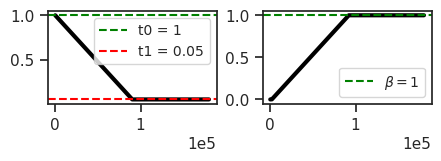

In [6]:
tr.show_schedules()

## Train

* Takes < 2h

In [ ]:
comment = tr.cfg.name()
tr.train(comment=comment)

## Eval

* I'll just load the model I have previously fit
* Download checkpoint on Box: ```PoissonVAE > models > pois-conv-mnist```

In [7]:
tr, meta = load_model_lite(
    path=pjoin(tmp_dir, 'Dekel', 'pois-conv-mnist'),
    device=device,
    verbose=True,
)
print(meta)

# params: 7.4 M

{
    'checkpoint': 600,
    'global_step': 180000,
    'file': 'PoissonVAE+TrainerVAE-0600_(2024_04_23,17:18).pt',
    'path': '/home/hadi/Dropbox/git/jb-vae/tmp/Dekel/pois-conv-mnist'
}

### Loss vld

In [8]:
data, loss, rates = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 27.370872, 'kl': 9.16358, 'kl_diag': 0.9163579, 'tot': 36.534454}

### Identify dead neurons

In [9]:
dead_thres = 0 # 0.002
dead = loss['kl_diag'] < dead_thres
dead.sum()

0

In [10]:
loss['kl_diag']

array([0.7481766 , 0.8595464 , 0.81775534, 0.9359781 , 1.0022541 ,
       1.0127685 , 0.9024006 , 0.9385641 , 0.9376316 , 1.0085043 ],
      dtype=float32)

### Spike counts

In [11]:
lifetime, population, percents = sparse_score(data['z'], cutoff=0.005)
percents

{'0': 54.8,
 '1': 12.6,
 '2': 11.3,
 '3': 8.5,
 '4': 5.6,
 '5': 3.3,
 '6': 1.9,
 '7': 1.0,
 '8': 0.5,
 '9': 0.2,
 '10+': 0.2}

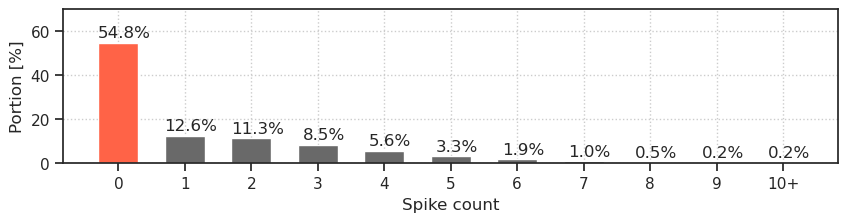

In [12]:
fig, ax = create_figure(1, 1, (10.0, 2.0))

max_val = float(list(percents.values())[0])
ax.set(
    xlabel='Spike count',
    ylabel='Portion [%]',
    ylim=(0, (np.ceil(max_val / 10) + 1) * 10),
)

colors = ['tomato' if lbl == '0' else 'dimgrey' for lbl in percents]
bars = ax.bar(percents.keys(), percents.values(), color=colors, width=0.6)

for bar in bars:
    y = bar.get_height()
    x = bar.get_x() + 1.3 * bar.get_width() / 2
    plt.text(x, y + 1, f'{y:0.1f}%', ha='center', va='bottom')

ax.locator_params(axis='y', nbins=5)

ax.grid()
plt.show()

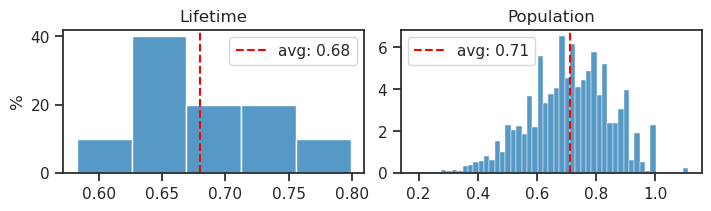

In [13]:
fig, axes = create_figure(1, 2, (7, 2), layout='constrained')

sns.histplot(lifetime, stat='percent', ax=axes[0])
sns.histplot(population, stat='percent', ax=axes[1])

for i, x2p in enumerate([lifetime, population]):
    _a, _med = np.nanmean(x2p), np.nanmedian(x2p)
    # axes[i].axvline(_med, color='g', ls='--', label=f'median: {_med:0.2f}')
    axes[i].axvline(_a, color='r', ls='--', label=f'avg: {_a:0.2f}')

add_legend(axes)
axes[0].set(title='Lifetime', ylabel='%')
axes[1].set(title='Population', ylabel='')
plt.show()

## Recon + Samples

In [16]:
tr.model.temp, tr.cfg.kl_beta

(tensor(0.0500, device='cuda:1'), 1.0)

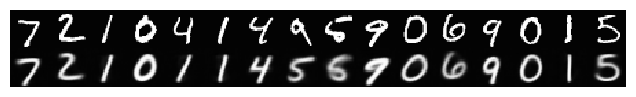

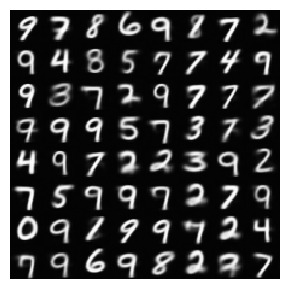

In [25]:
tr.show_recon(t=0.0), tr.show_samples(t=0.0);